# Optimización de Función de Transferencia con Algoritmos Genéticos

## Datos

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Descarga directo del Drive, no hace falta arrastrar
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1-EGArsCSAoDEmAF_B7hMa18AOKxpWjzc&confirm=t" -O sistema.csv

--2023-12-15 23:45:41--  https://drive.google.com/uc?export=download&id=1-EGArsCSAoDEmAF_B7hMa18AOKxpWjzc&confirm=t
Resolving drive.google.com (drive.google.com)... 173.194.217.100, 173.194.217.101, 173.194.217.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/86kepnfesg30540mbstr8qdl8se90kun/1702683900000/12225850433951268217/*/1-EGArsCSAoDEmAF_B7hMa18AOKxpWjzc?e=download&uuid=d7658289-4d47-462e-9932-589503886cd4 [following]
--2023-12-15 23:45:41--  https://doc-0c-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/86kepnfesg30540mbstr8qdl8se90kun/1702683900000/12225850433951268217/*/1-EGArsCSAoDEmAF_B7hMa18AOKxpWjzc?e=download&uuid=d7658289-4d47-462e-9932-589503886cd4
Resolving doc-0c-9c-docs.googleusercontent.com (doc-0c-9c-docs.googleusercontent.com)... 173.194

In [3]:
# Lectura de los datos relevados del sistema

datos = pd.read_csv("sistema.csv")
t = np.array(datos['t'])
y = np.array(datos['Amplitud'])

Text(0.5, 0, 'Tiempo (s)')

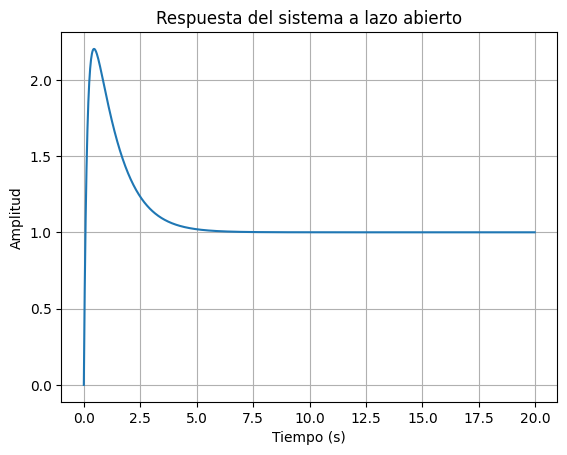

In [4]:
plt.plot(t, y)
plt.grid(True)
plt.title("Respuesta del sistema a lazo abierto")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo (s)")

## Ejemplo: Control para función de transferencia

In [5]:
!pip install control        # Librería orientada al control, permite gestionar la función de transferencia y obtener la respuesta al escalón (y otras cosas)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 4.8 MB/s eta 0:00:00


In [6]:
import control as ct

# Modelo como función de transferencia (tf)
num_opt = [16.42, 5.352]          # Numerador tf
den_opt = [1.0, 6.458, 5.352]     # Denominador tf
sys_opt = ct.tf(num_opt, den_opt) # Lazo abierto
print(sys_opt)


   16.42 s + 5.352
---------------------
s^2 + 6.458 s + 5.352



In [7]:
# Respuesta al escalón, lazo abierto
# Salida que presenta esta función frente a una entrada en escalón
_, y_opt = ct.step_response(sys_opt, t)     # Como argumento entra nuestro vector de tiempos, así las salidas son comparables directamente

Text(0.5, 0, 'Tiempo (s)')

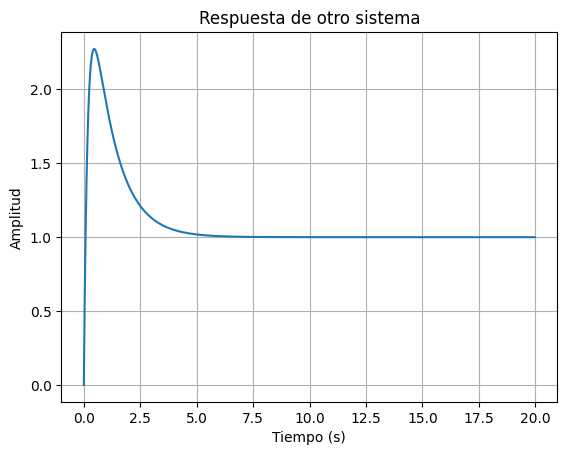

In [8]:
import matplotlib.pyplot as plt
#Graficas
plt.plot(t, y_opt)
plt.grid(True)
plt.title("Respuesta de otro sistema")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo (s)")

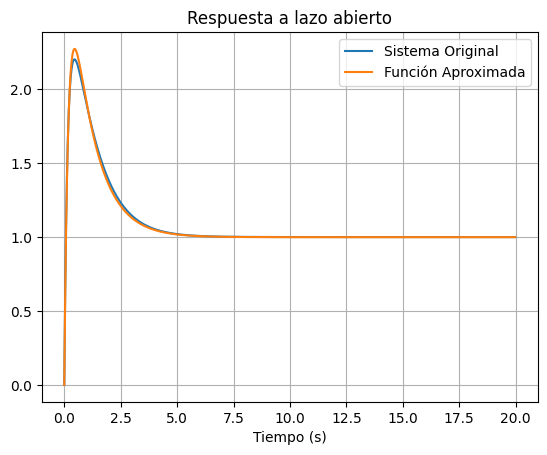

In [9]:
#Graficas
plt.plot(t, y, t, y_opt)
plt.grid(True)
plt.title("Respuesta a lazo abierto")
plt.xlabel("Amplitud")
plt.xlabel("Tiempo (s)")
plt.legend(["Sistema Original", "Función Aproximada"])

### Ejemplo: Métricas para ajuste de curva

In [10]:
# MSE
error = np.square(np.subtract(y, y_opt)).mean()
print(error)

0.00017340695907514648


In [11]:
# RMSE
error = np.sqrt(np.square(np.subtract(y, y_opt)).mean())
print(error)

0.01316840761349475


### Ejemplo: Diagramas

Text(0.5, 1.0, 'Diagrama de Bode')

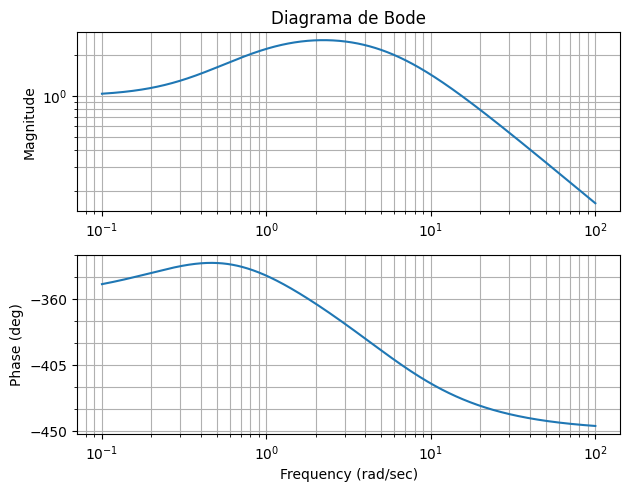

In [12]:
# Diagrama de Bode
mag, phase, omega = ct.bode_plot(sys_opt)
plt.tight_layout()
ax1, ax2 = plt.gcf().axes
plt.sca(ax1)
plt.title("Diagrama de Bode")

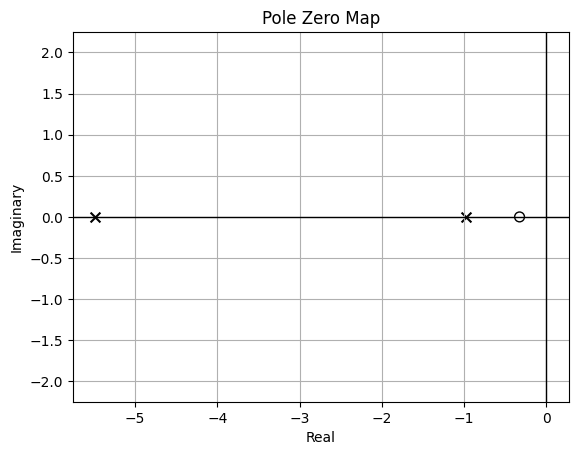

In [13]:
from control.pzmap import pzmap

# Diagrama de polos y zeros:
polos, zeros = pzmap(sys_opt), plt.grid(True)

## Optimización DEAP

In [14]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00


In [15]:
# Importaciones para AG
from deap import algorithms #incluye implementaciones completas de algoritmos genéticos, eaSimple por ejemplo. Se muestra un ejemplo en dónde hacemos a mano algo equivalente.
from deap import base #incluye las clases base de deap. En concreto dos son importantes en nuestro ejemplo, base.Fitness y base.Toolbox.
from deap import creator #permite crear clases nuevas.
from deap import tools #herramientas para implementar los algoritmos genéticos: operadores genéticos (selección, cruce y mutación), hallofFame, estadística, registro de evolución, etc.

import random

## Función para evaluación

In [16]:
ORDEN_MAXIMO = 3    # Define el máximo orden para construir los genes y la función de transferencia asociada

def evaluate(individuo):
    num = np.array(individuo[:ORDEN_MAXIMO-1])
    den = np.array([1] + individuo[ORDEN_MAXIMO-1:])

    try:
        # No todas las combinaciones generarán una función de transferencia válida
        sys_individio = ct.tf(num, den) #Lazo abierto
        _, y_individuo = ct.step_response(sys_individio, t)
    except:
        # Penalizo fuertemente si sucede
        return (10000,)

    # MSE
    #error = np.square(np.subtract(y, y_individuo)).mean()

    # RMSE
    error = np.sqrt(np.square(np.subtract(y, y_individuo)).mean())

    return (error,)

In [17]:
def get_response_by_individuo(individuo):
    """
    Para obtener el vector de respuesta a partir de los genes de un individuo.
    Imprime además la función de transferencia asociada.
    """
    num = np.array(individuo[:ORDEN_MAXIMO-1])
    den = np.array([1] + individuo[ORDEN_MAXIMO-1:])

    sys_individio = ct.tf(num, den) #Lazo abierto
    print(sys_individio)
    _, y_individuo = ct.step_response(sys_individio, t)

    return y_individuo

## Instancias AG

### Opción N°1

In [18]:
# OPCIÓN 1
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Los pesos definen si se Maximiza (1) o Minimiza (-1) en la Optimización
creator.create("Individual", list, fitness=creator.FitnessMin)

# Registro de las funciones necesarias
toolbox = base.Toolbox()

# Funciones de inicilización del individuo y de la población
toolbox.register("attr_float", random.uniform, 0.0, 15.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, (ORDEN_MAXIMO*2)-2)     # Se crea un individuo "modelo"
toolbox.register("population", tools.initRepeat, list, toolbox.individual)                              # Se crea la población con individuos como el "modelo"

# Definiciones respecto a cómo se muta, cómo se eligen, como se reproducen los individuos
toolbox.register("mate", tools.cxTwoPoint)                      # Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)         # Mutacion
toolbox.register("select", tools.selTournament, tournsize=3)    # Selecion

# Función de evaluación
toolbox.register("evaluate", evaluate) # Evaluacion, se apunta a nuestra función

### Opción N°2

In [ ]:
# OPCIÓN 2
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Los pesos definen si se Maximiza (1) o Minimiza (-1) en la Optimización
creator.create("Individual", list, fitness=creator.FitnessMin)

# Registro de las funciones necesarias
toolbox = base.Toolbox()

toolbox.register("attr_float", random.uniform, 0.0, 17.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, (ORDEN_MAXIMO*2)-2)     # Se crea un individuo "modelo"
toolbox.register("population", tools.initRepeat, list, toolbox.individual)                                       # Se crea la población con individuos como el "modelo"

# Definiciones respecto a cómo se muta, cómo se eligen, como se reproducen los individuos
toolbox.register("mate", tools.cxTwoPoint)                      # Ver operadores en: https://deap.readthedocs.io/en/master/api/tools.html#operators-1
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

# Función de evaluación
toolbox.register("evaluate", evaluate) # Evaluacion, se apunta a nuestra función

/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Parámetros

In [19]:
N_POP = 1000  # Tamaño de la población
CXPB = 0.5  # Probabilidad de crossover
MUTPB = 0.2 # Probabilidad de mutación
NGEN = 15   # Cantidad de generaciones

print(
    "Tamaño población: {}\nProbabilidad de crossover: {}\nProbabilida de mutación: {}\nGeneraciones totales: {}".format(
        N_POP, CXPB, MUTPB, NGEN
    )
)

Tamaño población: 1000
Probabilidad de crossover: 0.5
Probabilida de mutación: 0.2
Generaciones totales: 15


## Implementación eaSimple

In [20]:
pop = toolbox.population(N_POP) # Población inicial
hof = tools.HallOfFame(10) # Espacio para guardar los mejores individuos

# Estadisticas a almacenar de las generaciones
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook() # Para almacenar todas las estadísticas calculadas por generación en un solo objeto.

# Evaluación sencilla del AG
best, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min     	max 
0  	1000  	1.46761	3.09021	0.114088	45.2
1  	599   	1.88578	32.4516	0.107547	1021.17
2  	577   	3.1556 	50.9588	0.107547	1491.19
3  	571   	3.57826	52.7098	0.0565155	1195.78
4  	651   	2.30929	38.8   	0.0565155	1163.03
5  	611   	2.46233	44.7887	0.0877891	1379.16
6  	601   	1.87079	39.6307	0.091019 	1250.83
7  	602   	4.25594	63.3753	0.0524419	1253.23
8  	651   	1.52743	18.4792	0.0517442	421.913
9  	623   	1.852  	28.1785	0.0413927	750.142
10 	599   	1.87353	23.544 	0.0413927	584.106
11 	608   	0.554733	1.75218	0.0413927	22.8529
12 	628   	1.59599 	26.0918	0.0398262	727.311
13 	604   	2.03722 	26.8958	0.0388414	496.469
14 	599   	0.878439	15.0692	0.0384528	474.894
15 	615   	1.24248 	18.8742	0.0384528	491.892


## Implementación eaMuPlusLambda

In [25]:
N_POP = 1000  # Tamaño de la población
CXPB = 0.5 # Probabilidad de crossover
MUTPB = 0.1 # Probabilidad de mutación
NGEN = 15 # Cantidad de generaciones


pop = toolbox.population(N_POP)
MU, LAMBDA = len(pop), len(pop) # Parámetros para implementación eaMuPlusLambda

hof = tools.HallOfFame(10) # Espacio para guardar los mejores individuos, se guarda el mejor en este caso (1)

implementacion = "eaMuPlusLambda"
best, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU,
                                            LAMBDA, CXPB, MUTPB,
                                            NGEN, stats=stats,
                                            halloffame=hof)

gen	nevals	avg    	std    	min      	max  
0  	1000  	1.48245	2.72041	0.0776634	37.19
1  	604   	0.4809 	0.289222	0.0776634	2.64196
2  	590   	0.308971	0.126657	0.0776634	1.33878
3  	603   	0.229819	0.0704603	0.071813 	0.530519
4  	586   	0.18233 	0.0498899	0.071813 	0.377766
5  	610   	0.14964 	0.0439717	0.071813 	0.460257
6  	601   	0.122632	0.0395297	0.059168 	0.568108
7  	570   	0.0993605	0.0317778	0.059168 	0.493845
8  	622   	0.0837785	0.0192115	0.0523064	0.415133
9  	589   	0.0755181	0.0067824	0.0498686	0.143428
10 	603   	0.0714348	0.00778498	0.0435642	0.235437
11 	605   	0.0667499	0.00709677	0.0435642	0.154591
12 	616   	0.0617633	0.00932886	0.0413854	0.20615 
13 	608   	0.0557241	0.0100889 	0.0413854	0.243757
14 	613   	0.0491533	0.00704413	0.0413854	0.0987133
15 	589   	0.0447423	0.0084355 	0.0413854	0.28234  


## Análisis de Resultados

In [26]:
def plot_evolucion(logbook):
    gen = logbook.select("gen")
    fit_mins = np.array(logbook.select("min"))
    fit_maxs = np.array(logbook.select("max"))
    fit_avgs = np.array(logbook.select("avg"))

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_avgs, "--k")

    ax1.fill_between(gen, fit_mins, fit_maxs,
                     where=fit_maxs >= fit_mins,
                     facecolor="g", alpha=0.2)

    ax1.set_xlabel("Generaciones")
    ax1.set_ylabel("Fitness")
    ax1.legend(["Min", "Max", "Avg"])
    plt.grid(True)
    plt.show()

Mejor fitness:  (0.03693182920333351,)
Mejor individuo:  [12.725116991756037, 4.786468071007165, 5.032224133414845, 4.67686079221763]


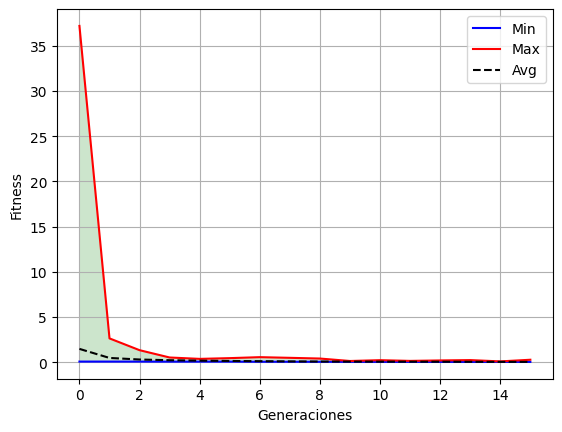

In [27]:
print("Mejor fitness: ", hof[0].fitness.values)
print("Mejor individuo: ", hof[0])
plot_evolucion(logbook)

In [28]:
# Obtengo la salida para la función que genera el mejor individuo
y_best_individuo = get_response_by_individuo(hof[0])


   12.73 s + 4.786
---------------------
s^2 + 5.032 s + 4.677



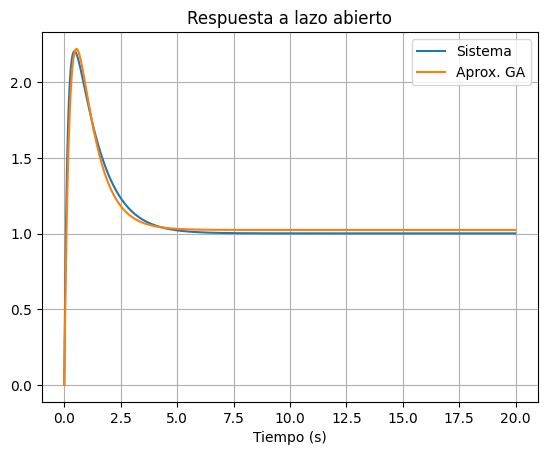

In [29]:
plt.plot(t, y, t, y_best_individuo)
plt.grid(True)
plt.title("Respuesta a lazo abierto")
plt.xlabel("Amplitud")
plt.xlabel("Tiempo (s)")
plt.legend(["Sistema", "Aprox. GA"])

# Referencias y Recursos



*   https://python-control.readthedocs.io/en/0.9.3.post2/
*   https://deap.readthedocs.io/en/master/api/tools.html#operators-1

